<a href="https://colab.research.google.com/github/JaiBhagat/ERA-Session-9/blob/main/S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import albumentations as A
import cv2
from model import Net
from utils import train, test,CustomDataset


In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms

# PyTorch Train Phase transformations
train_transforms_torch = transforms.Compose([
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                       ])

# Albumentations Train Phase transformations
train_transforms_albu = A.Compose([
                                       A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                       A.HorizontalFlip(p=0.5),
                                       A.ColorJitter(p=0.2,brightness=0.2,contrast=0.2,saturation=0.2,hue=0.2),
                                      #  A.RandomBrightnessContrast(p=0.2),
                                      #  A.RandomContrast(limit=0.2),
                                       A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.2,border_mode=cv2.BORDER_REFLECT_101),
                                       A.CoarseDropout(max_holes=1, max_height=16,fill_value=(0.4914, 0.4822, 0.4465),mask_fill_value = None),
                                       ToTensorV2(),

                                       ])

# PyTorch Test Phase transformations
test_transforms_torch = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [4]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms_albu)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms_torch)

100%|██████████| 170498071/170498071 [00:13<00:00, 12945759.55it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
from torch.utils.data import Dataset
import cv2

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#instead of using torchvision's CIFAR10 directly, using this CustomDataset class and pass the CIFAR10 dataset's data and targets to it:
from torchvision.datasets import CIFAR10

# Load CIFAR10 dataset
dataset = CIFAR10(root='./data', train=True, download=True)

# Create the custom dataset
custom_dataset = CustomDataset(dataset.data, dataset.targets, transform=train_transforms_albu)

# Now, create your data loader with this custom dataset
train_loader = torch.utils.data.DataLoader(custom_dataset, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


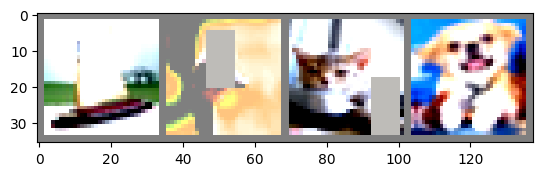

ship  bird  cat   dog  


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

#S9 Model

In [15]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              27
            Conv2d-2           [-1, 32, 32, 32]              96
depthwise_separable_conv-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
              ReLU-5           [-1, 32, 32, 32]               0
           Dropout-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
          Dropout-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
          Dropout-14        

In [19]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.023, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


EPOCHS = 200
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.7480008602142334 Batch_id=97 Accuracy=24.72: 100%|██████████| 98/98 [00:14<00:00,  6.87it/s]



Test set: Average loss: 1.6914, Accuracy: 3684/10000 (36.84%)

EPOCH: 1


Loss=1.3948301076889038 Batch_id=95 Accuracy=42.21:  97%|█████████▋| 95/98 [00:12<00:00,  8.06it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loss=1.483482003211975 Batch_id=97 Accuracy=42.29: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s]



Test set: Average loss: 1.3917, Accuracy: 5108/10000 (51.08%)

EPOCH: 2


Loss=1.3566865921020508 Batch_id=47 Accuracy=48.71:  48%|████▊     | 47/98 [00:06<00:05,  9.20it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multipro


Test set: Average loss: 1.1807, Accuracy: 5796/10000 (57.96%)

EPOCH: 3


Loss=1.32697594165802 Batch_id=67 Accuracy=54.33:  68%|██████▊   | 67/98 [00:09<00:03,  9.48it/s]  Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/


Test set: Average loss: 1.0276, Accuracy: 6299/10000 (62.99%)

EPOCH: 4


Loss=1.2019981145858765 Batch_id=43 Accuracy=57.48:  44%|████▍     | 43/98 [00:06<00:06,  8.68it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback


Test set: Average loss: 1.0697, Accuracy: 6337/10000 (63.37%)

EPOCH: 5


Loss=1.1108086109161377 Batch_id=63 Accuracy=60.40:  65%|██████▌   | 64/98 [00:07<00:03,  9.72it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
AssertionError    : self._shutdown_workers()can only test a child process

  File "/usr/local/lib/python3.10/dist-packages/torc


Test set: Average loss: 0.9224, Accuracy: 6829/10000 (68.29%)

EPOCH: 6


Loss=1.0440300703048706 Batch_id=39 Accuracy=61.77:  41%|████      | 40/98 [00:05<00:06,  8.99it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        self._shutdown_workers()    
if w.is_alive():self._shutdown_workers


Test set: Average loss: 0.8462, Accuracy: 7034/10000 (70.34%)

EPOCH: 7


Loss=1.1327688694000244 Batch_id=35 Accuracy=64.25:  36%|███▌      | 35/98 [00:06<00:10,  6.15it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a1


Test set: Average loss: 0.8645, Accuracy: 7037/10000 (70.37%)

EPOCH: 8


Loss=0.9990196228027344 Batch_id=11 Accuracy=65.46:  12%|█▏        | 12/98 [00:02<00:12,  6.92it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process

Exception ignored in:   File "/usr/local/lib/python3


Test set: Average loss: 0.8220, Accuracy: 7128/10000 (71.28%)

EPOCH: 9


Loss=0.9420729875564575 Batch_id=31 Accuracy=67.07:  32%|███▏      | 31/98 [00:04<00:07,  9.44it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>Traceback (most recent call last):
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):

    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        if w.is_alive():self._shutdown_workers()self._shutdown_workers(


Test set: Average loss: 0.7257, Accuracy: 7533/10000 (75.33%)

EPOCH: 10


Loss=0.9229974150657654 Batch_id=7 Accuracy=68.36:   8%|▊         | 8/98 [00:01<00:10,  8.38it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Exception ignored in: Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310><function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

self._shutdown_workers()
    
self._shutdown_workers()Traceback (most recent call last):
  File "


Test set: Average loss: 0.7624, Accuracy: 7398/10000 (73.98%)

EPOCH: 11


Loss=1.0069769620895386 Batch_id=3 Accuracy=67.14:   4%|▍         | 4/98 [00:01<00:18,  5.09it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168


Test set: Average loss: 0.6907, Accuracy: 7578/10000 (75.78%)

EPOCH: 12


Loss=0.7562809586524963 Batch_id=3 Accuracy=70.41:   4%|▍         | 4/98 [00:01<00:18,  5.19it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers()AssertionError
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", lin


Test set: Average loss: 0.7307, Accuracy: 7526/10000 (75.26%)

EPOCH: 13


  0%|          | 0/98 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>self._shutdown_workers()

Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):
  File "/usr/


Test set: Average loss: 0.8338, Accuracy: 7188/10000 (71.88%)

EPOCH: 14


  0%|          | 0/98 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
Exception ignored in: Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310><function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a168d8310>    
Exception ignored in: 
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    AssertionErrorself._shutdown_workers(): 
can only test a child process  


Test set: Average loss: 0.6662, Accuracy: 7754/10000 (77.54%)

EPOCH: 15


Loss=0.8261621594429016 Batch_id=97 Accuracy=71.26: 100%|██████████| 98/98 [00:12<00:00,  7.72it/s]



Test set: Average loss: 0.6641, Accuracy: 7724/10000 (77.24%)

EPOCH: 16


Loss=0.7557589411735535 Batch_id=97 Accuracy=71.92: 100%|██████████| 98/98 [00:13<00:00,  7.47it/s]



Test set: Average loss: 0.6258, Accuracy: 7858/10000 (78.58%)

EPOCH: 17


Loss=0.8798855543136597 Batch_id=97 Accuracy=72.44: 100%|██████████| 98/98 [00:14<00:00,  6.88it/s]



Test set: Average loss: 0.6248, Accuracy: 7878/10000 (78.78%)

EPOCH: 18


Loss=0.8187411427497864 Batch_id=97 Accuracy=72.44: 100%|██████████| 98/98 [00:13<00:00,  7.38it/s]



Test set: Average loss: 0.6498, Accuracy: 7821/10000 (78.21%)

EPOCH: 19


Loss=0.7528306841850281 Batch_id=97 Accuracy=72.90: 100%|██████████| 98/98 [00:13<00:00,  7.54it/s]



Test set: Average loss: 0.5776, Accuracy: 7996/10000 (79.96%)

EPOCH: 20


Loss=0.8382452130317688 Batch_id=97 Accuracy=73.23: 100%|██████████| 98/98 [00:12<00:00,  7.94it/s]



Test set: Average loss: 0.6688, Accuracy: 7728/10000 (77.28%)

EPOCH: 21


Loss=0.7224876880645752 Batch_id=97 Accuracy=73.70: 100%|██████████| 98/98 [00:12<00:00,  7.70it/s]



Test set: Average loss: 0.6002, Accuracy: 7956/10000 (79.56%)

EPOCH: 22


Loss=0.8445928692817688 Batch_id=97 Accuracy=74.03: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]



Test set: Average loss: 0.6037, Accuracy: 7960/10000 (79.60%)

EPOCH: 23


Loss=0.7371851801872253 Batch_id=97 Accuracy=74.17: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]



Test set: Average loss: 0.5990, Accuracy: 7987/10000 (79.87%)

EPOCH: 24


Loss=0.6763123273849487 Batch_id=97 Accuracy=74.36: 100%|██████████| 98/98 [00:12<00:00,  7.63it/s]



Test set: Average loss: 0.6312, Accuracy: 7910/10000 (79.10%)

EPOCH: 25


Loss=0.764739990234375 Batch_id=97 Accuracy=74.89: 100%|██████████| 98/98 [00:13<00:00,  7.46it/s]



Test set: Average loss: 0.5734, Accuracy: 8027/10000 (80.27%)

EPOCH: 26


Loss=0.7358580827713013 Batch_id=97 Accuracy=74.68: 100%|██████████| 98/98 [00:12<00:00,  7.81it/s]



Test set: Average loss: 0.5573, Accuracy: 8123/10000 (81.23%)

EPOCH: 27


Loss=0.6140778660774231 Batch_id=97 Accuracy=75.06: 100%|██████████| 98/98 [00:13<00:00,  7.46it/s]



Test set: Average loss: 0.5570, Accuracy: 8093/10000 (80.93%)

EPOCH: 28


Loss=0.5935724973678589 Batch_id=97 Accuracy=75.33: 100%|██████████| 98/98 [00:14<00:00,  6.68it/s]



Test set: Average loss: 0.6072, Accuracy: 7959/10000 (79.59%)

EPOCH: 29


Loss=0.6437410116195679 Batch_id=97 Accuracy=75.46: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]



Test set: Average loss: 0.5784, Accuracy: 8042/10000 (80.42%)

EPOCH: 30


Loss=0.6488422155380249 Batch_id=97 Accuracy=76.02: 100%|██████████| 98/98 [00:13<00:00,  7.46it/s]



Test set: Average loss: 0.5624, Accuracy: 8065/10000 (80.65%)

EPOCH: 31


Loss=0.6807096004486084 Batch_id=97 Accuracy=75.73: 100%|██████████| 98/98 [00:13<00:00,  7.43it/s]



Test set: Average loss: 0.5319, Accuracy: 8218/10000 (82.18%)

EPOCH: 32


Loss=0.6527844667434692 Batch_id=97 Accuracy=76.08: 100%|██████████| 98/98 [00:12<00:00,  8.03it/s]



Test set: Average loss: 0.5684, Accuracy: 8137/10000 (81.37%)

EPOCH: 33


Loss=0.6194171905517578 Batch_id=97 Accuracy=76.09: 100%|██████████| 98/98 [00:13<00:00,  7.48it/s]



Test set: Average loss: 0.5498, Accuracy: 8153/10000 (81.53%)

EPOCH: 34


Loss=0.8028519153594971 Batch_id=97 Accuracy=76.29: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s]



Test set: Average loss: 0.5274, Accuracy: 8223/10000 (82.23%)

EPOCH: 35


Loss=0.6691418290138245 Batch_id=97 Accuracy=76.50: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]



Test set: Average loss: 0.5185, Accuracy: 8250/10000 (82.50%)

EPOCH: 36


Loss=0.6059434413909912 Batch_id=97 Accuracy=76.70: 100%|██████████| 98/98 [00:12<00:00,  7.67it/s]



Test set: Average loss: 0.5542, Accuracy: 8146/10000 (81.46%)

EPOCH: 37


Loss=0.6164984107017517 Batch_id=97 Accuracy=76.67: 100%|██████████| 98/98 [00:13<00:00,  7.54it/s]



Test set: Average loss: 0.5028, Accuracy: 8321/10000 (83.21%)

EPOCH: 38


Loss=0.6459526419639587 Batch_id=97 Accuracy=77.14: 100%|██████████| 98/98 [00:12<00:00,  7.66it/s]



Test set: Average loss: 0.4955, Accuracy: 8342/10000 (83.42%)

EPOCH: 39


Loss=0.6137130856513977 Batch_id=97 Accuracy=77.12: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]



Test set: Average loss: 0.4920, Accuracy: 8354/10000 (83.54%)

EPOCH: 40


Loss=0.6627112627029419 Batch_id=97 Accuracy=77.32: 100%|██████████| 98/98 [00:13<00:00,  7.51it/s]



Test set: Average loss: 0.4950, Accuracy: 8340/10000 (83.40%)

EPOCH: 41


Loss=0.6927242279052734 Batch_id=97 Accuracy=77.32: 100%|██████████| 98/98 [00:13<00:00,  7.50it/s]



Test set: Average loss: 0.5213, Accuracy: 8276/10000 (82.76%)

EPOCH: 42


Loss=0.6273150444030762 Batch_id=97 Accuracy=77.46: 100%|██████████| 98/98 [00:13<00:00,  7.51it/s]



Test set: Average loss: 0.5149, Accuracy: 8309/10000 (83.09%)

EPOCH: 43


Loss=0.5700880289077759 Batch_id=97 Accuracy=77.46: 100%|██████████| 98/98 [00:12<00:00,  7.86it/s]



Test set: Average loss: 0.5193, Accuracy: 8279/10000 (82.79%)

EPOCH: 44


Loss=0.6159905195236206 Batch_id=97 Accuracy=77.59: 100%|██████████| 98/98 [00:13<00:00,  7.53it/s]



Test set: Average loss: 0.4948, Accuracy: 8329/10000 (83.29%)

EPOCH: 45


Loss=0.670348584651947 Batch_id=97 Accuracy=77.97: 100%|██████████| 98/98 [00:13<00:00,  7.53it/s]



Test set: Average loss: 0.5132, Accuracy: 8307/10000 (83.07%)

EPOCH: 46


Loss=0.5879417061805725 Batch_id=97 Accuracy=77.82: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]



Test set: Average loss: 0.5320, Accuracy: 8268/10000 (82.68%)

EPOCH: 47


Loss=0.6504334211349487 Batch_id=97 Accuracy=77.80: 100%|██████████| 98/98 [00:13<00:00,  7.46it/s]



Test set: Average loss: 0.4954, Accuracy: 8368/10000 (83.68%)

EPOCH: 48


Loss=0.686936616897583 Batch_id=97 Accuracy=78.27: 100%|██████████| 98/98 [00:12<00:00,  7.64it/s]



Test set: Average loss: 0.5019, Accuracy: 8346/10000 (83.46%)

EPOCH: 49


Loss=0.6629683375358582 Batch_id=97 Accuracy=78.35: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s]



Test set: Average loss: 0.4960, Accuracy: 8364/10000 (83.64%)

EPOCH: 50


Loss=0.5142934918403625 Batch_id=97 Accuracy=78.55: 100%|██████████| 98/98 [00:14<00:00,  6.89it/s]



Test set: Average loss: 0.4769, Accuracy: 8449/10000 (84.49%)

EPOCH: 51


Loss=0.5630332231521606 Batch_id=97 Accuracy=78.14: 100%|██████████| 98/98 [00:13<00:00,  7.39it/s]



Test set: Average loss: 0.4859, Accuracy: 8369/10000 (83.69%)

EPOCH: 52


Loss=0.6176190376281738 Batch_id=97 Accuracy=78.61: 100%|██████████| 98/98 [00:13<00:00,  7.27it/s]



Test set: Average loss: 0.4960, Accuracy: 8336/10000 (83.36%)

EPOCH: 53


Loss=0.6048494577407837 Batch_id=97 Accuracy=78.63: 100%|██████████| 98/98 [00:12<00:00,  7.74it/s]



Test set: Average loss: 0.4661, Accuracy: 8422/10000 (84.22%)

EPOCH: 54


Loss=0.5664501786231995 Batch_id=97 Accuracy=78.71: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s]



Test set: Average loss: 0.4855, Accuracy: 8404/10000 (84.04%)

EPOCH: 55


Loss=0.5959731340408325 Batch_id=97 Accuracy=78.90: 100%|██████████| 98/98 [00:13<00:00,  7.50it/s]



Test set: Average loss: 0.4703, Accuracy: 8438/10000 (84.38%)

EPOCH: 56


Loss=0.6172703504562378 Batch_id=97 Accuracy=78.64: 100%|██████████| 98/98 [00:13<00:00,  7.33it/s]



Test set: Average loss: 0.4668, Accuracy: 8457/10000 (84.57%)

EPOCH: 57


Loss=0.678625226020813 Batch_id=97 Accuracy=78.96: 100%|██████████| 98/98 [00:13<00:00,  7.39it/s]



Test set: Average loss: 0.4541, Accuracy: 8452/10000 (84.52%)

EPOCH: 58


Loss=0.6478513479232788 Batch_id=97 Accuracy=79.18: 100%|██████████| 98/98 [00:13<00:00,  7.44it/s]



Test set: Average loss: 0.4728, Accuracy: 8450/10000 (84.50%)

EPOCH: 59


Loss=0.6600233316421509 Batch_id=97 Accuracy=78.83: 100%|██████████| 98/98 [00:12<00:00,  7.94it/s]



Test set: Average loss: 0.4697, Accuracy: 8455/10000 (84.55%)

EPOCH: 60


Loss=0.6076568961143494 Batch_id=97 Accuracy=79.05: 100%|██████████| 98/98 [00:12<00:00,  7.55it/s]



Test set: Average loss: 0.4751, Accuracy: 8366/10000 (83.66%)

EPOCH: 61


Loss=0.6712964177131653 Batch_id=97 Accuracy=79.01: 100%|██████████| 98/98 [00:13<00:00,  7.45it/s]



Test set: Average loss: 0.4583, Accuracy: 8480/10000 (84.80%)

EPOCH: 62


Loss=0.6175121665000916 Batch_id=97 Accuracy=79.32: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]



Test set: Average loss: 0.4646, Accuracy: 8498/10000 (84.98%)

EPOCH: 63


Loss=0.47283944487571716 Batch_id=97 Accuracy=79.07: 100%|██████████| 98/98 [00:13<00:00,  7.37it/s]



Test set: Average loss: 0.4620, Accuracy: 8477/10000 (84.77%)

EPOCH: 64


Loss=0.6071616411209106 Batch_id=97 Accuracy=79.52: 100%|██████████| 98/98 [00:12<00:00,  7.64it/s]



Test set: Average loss: 0.5154, Accuracy: 8318/10000 (83.18%)

EPOCH: 65


Loss=0.5708123445510864 Batch_id=97 Accuracy=79.56: 100%|██████████| 98/98 [00:13<00:00,  7.51it/s]



Test set: Average loss: 0.4908, Accuracy: 8423/10000 (84.23%)

EPOCH: 66


Loss=0.5345656275749207 Batch_id=97 Accuracy=79.44: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]



Test set: Average loss: 0.4692, Accuracy: 8460/10000 (84.60%)

EPOCH: 67


Loss=0.5003325343132019 Batch_id=97 Accuracy=79.55: 100%|██████████| 98/98 [00:13<00:00,  7.48it/s]



Test set: Average loss: 0.4458, Accuracy: 8537/10000 (85.37%)

EPOCH: 68


Loss=0.6074647307395935 Batch_id=97 Accuracy=79.26: 100%|██████████| 98/98 [00:12<00:00,  7.55it/s]



Test set: Average loss: 0.4568, Accuracy: 8505/10000 (85.05%)

EPOCH: 69


Loss=0.7020139694213867 Batch_id=97 Accuracy=79.40: 100%|██████████| 98/98 [00:12<00:00,  7.59it/s]



Test set: Average loss: 0.4787, Accuracy: 8424/10000 (84.24%)

EPOCH: 70


Loss=0.5897084474563599 Batch_id=97 Accuracy=79.60: 100%|██████████| 98/98 [00:13<00:00,  7.46it/s]



Test set: Average loss: 0.4747, Accuracy: 8439/10000 (84.39%)

EPOCH: 71


Loss=0.5346512794494629 Batch_id=97 Accuracy=79.61: 100%|██████████| 98/98 [00:13<00:00,  7.35it/s]



Test set: Average loss: 0.4628, Accuracy: 8427/10000 (84.27%)

EPOCH: 72


Loss=0.6025581955909729 Batch_id=97 Accuracy=79.75: 100%|██████████| 98/98 [00:12<00:00,  7.64it/s]



Test set: Average loss: 0.4766, Accuracy: 8435/10000 (84.35%)

EPOCH: 73


Loss=0.5377574563026428 Batch_id=97 Accuracy=80.05: 100%|██████████| 98/98 [00:13<00:00,  7.51it/s]



Test set: Average loss: 0.4638, Accuracy: 8494/10000 (84.94%)

EPOCH: 74


Loss=0.5132718086242676 Batch_id=97 Accuracy=80.13: 100%|██████████| 98/98 [00:12<00:00,  7.65it/s]



Test set: Average loss: 0.4613, Accuracy: 8468/10000 (84.68%)

EPOCH: 75


Loss=0.5230063199996948 Batch_id=97 Accuracy=79.85: 100%|██████████| 98/98 [00:12<00:00,  7.66it/s]



Test set: Average loss: 0.4600, Accuracy: 8463/10000 (84.63%)

EPOCH: 76


Loss=0.5755982398986816 Batch_id=97 Accuracy=80.19: 100%|██████████| 98/98 [00:12<00:00,  7.64it/s]



Test set: Average loss: 0.4563, Accuracy: 8496/10000 (84.96%)

EPOCH: 77


Loss=0.7087705731391907 Batch_id=97 Accuracy=79.77: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]



Test set: Average loss: 0.4410, Accuracy: 8527/10000 (85.27%)

EPOCH: 78


Loss=0.5626107454299927 Batch_id=97 Accuracy=80.04: 100%|██████████| 98/98 [00:12<00:00,  7.62it/s]



Test set: Average loss: 0.4499, Accuracy: 8521/10000 (85.21%)

EPOCH: 79


Loss=0.4780276119709015 Batch_id=97 Accuracy=80.35: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]



Test set: Average loss: 0.4602, Accuracy: 8527/10000 (85.27%)

EPOCH: 80


Loss=0.5542477965354919 Batch_id=97 Accuracy=80.15: 100%|██████████| 98/98 [00:12<00:00,  7.61it/s]



Test set: Average loss: 0.4545, Accuracy: 8537/10000 (85.37%)

EPOCH: 81


Loss=0.608185887336731 Batch_id=97 Accuracy=80.22: 100%|██████████| 98/98 [00:13<00:00,  7.51it/s]



Test set: Average loss: 0.4535, Accuracy: 8552/10000 (85.52%)

EPOCH: 82


Loss=0.5763078927993774 Batch_id=97 Accuracy=80.29: 100%|██████████| 98/98 [00:13<00:00,  7.05it/s]



Test set: Average loss: 0.4685, Accuracy: 8441/10000 (84.41%)

EPOCH: 83


Loss=0.5396720170974731 Batch_id=97 Accuracy=80.47: 100%|██████████| 98/98 [00:12<00:00,  7.70it/s]



Test set: Average loss: 0.4675, Accuracy: 8495/10000 (84.95%)

EPOCH: 84


Loss=0.5527290105819702 Batch_id=97 Accuracy=80.15: 100%|██████████| 98/98 [00:12<00:00,  7.77it/s]



Test set: Average loss: 0.4539, Accuracy: 8475/10000 (84.75%)

EPOCH: 85


Loss=0.5445504188537598 Batch_id=97 Accuracy=80.60: 100%|██████████| 98/98 [00:12<00:00,  7.76it/s]



Test set: Average loss: 0.4686, Accuracy: 8453/10000 (84.53%)

EPOCH: 86


Loss=0.6165471076965332 Batch_id=97 Accuracy=80.46: 100%|██████████| 98/98 [00:12<00:00,  7.73it/s]



Test set: Average loss: 0.4499, Accuracy: 8514/10000 (85.14%)

EPOCH: 87


Loss=0.5930839776992798 Batch_id=97 Accuracy=80.63: 100%|██████████| 98/98 [00:11<00:00,  8.19it/s]



Test set: Average loss: 0.4448, Accuracy: 8545/10000 (85.45%)

EPOCH: 88


Loss=0.5469889640808105 Batch_id=97 Accuracy=80.64: 100%|██████████| 98/98 [00:12<00:00,  7.82it/s]



Test set: Average loss: 0.4781, Accuracy: 8458/10000 (84.58%)

EPOCH: 89


Loss=0.5198349356651306 Batch_id=97 Accuracy=80.76: 100%|██████████| 98/98 [00:12<00:00,  7.86it/s]



Test set: Average loss: 0.4474, Accuracy: 8569/10000 (85.69%)

EPOCH: 90


Loss=0.4731099307537079 Batch_id=97 Accuracy=80.55: 100%|██████████| 98/98 [00:12<00:00,  7.72it/s]



Test set: Average loss: 0.4518, Accuracy: 8519/10000 (85.19%)

EPOCH: 91


Loss=0.4586173892021179 Batch_id=97 Accuracy=80.76: 100%|██████████| 98/98 [00:12<00:00,  7.75it/s]



Test set: Average loss: 0.4405, Accuracy: 8543/10000 (85.43%)

EPOCH: 92


Loss=0.5517649054527283 Batch_id=97 Accuracy=80.80: 100%|██████████| 98/98 [00:12<00:00,  7.72it/s]



Test set: Average loss: 0.4462, Accuracy: 8518/10000 (85.18%)

EPOCH: 93


Loss=0.64089435338974 Batch_id=97 Accuracy=80.89: 100%|██████████| 98/98 [00:13<00:00,  7.03it/s]



Test set: Average loss: 0.4287, Accuracy: 8570/10000 (85.70%)

EPOCH: 94


Loss=0.5633025765419006 Batch_id=97 Accuracy=80.67: 100%|██████████| 98/98 [00:13<00:00,  7.50it/s]



Test set: Average loss: 0.4433, Accuracy: 8511/10000 (85.11%)

EPOCH: 95


Loss=0.634364128112793 Batch_id=97 Accuracy=81.12: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]



Test set: Average loss: 0.4288, Accuracy: 8578/10000 (85.78%)

EPOCH: 96


Loss=0.5479022860527039 Batch_id=97 Accuracy=81.04: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s]



Test set: Average loss: 0.4324, Accuracy: 8571/10000 (85.71%)

EPOCH: 97


Loss=0.6060107350349426 Batch_id=97 Accuracy=80.92: 100%|██████████| 98/98 [00:12<00:00,  7.75it/s]



Test set: Average loss: 0.4696, Accuracy: 8492/10000 (84.92%)

EPOCH: 98


Loss=0.48174595832824707 Batch_id=97 Accuracy=80.83: 100%|██████████| 98/98 [00:12<00:00,  7.77it/s]



Test set: Average loss: 0.4393, Accuracy: 8569/10000 (85.69%)

EPOCH: 99


Loss=0.575049877166748 Batch_id=97 Accuracy=81.10: 100%|██████████| 98/98 [00:12<00:00,  7.75it/s]



Test set: Average loss: 0.4200, Accuracy: 8632/10000 (86.32%)

EPOCH: 100


Loss=0.4942188262939453 Batch_id=97 Accuracy=80.83: 100%|██████████| 98/98 [00:12<00:00,  7.82it/s]



Test set: Average loss: 0.4433, Accuracy: 8552/10000 (85.52%)

EPOCH: 101


Loss=0.4890654981136322 Batch_id=97 Accuracy=81.02: 100%|██████████| 98/98 [00:12<00:00,  7.68it/s]



Test set: Average loss: 0.4271, Accuracy: 8577/10000 (85.77%)

EPOCH: 102


Loss=0.554284393787384 Batch_id=97 Accuracy=81.23: 100%|██████████| 98/98 [00:12<00:00,  7.72it/s]



Test set: Average loss: 0.4560, Accuracy: 8513/10000 (85.13%)

EPOCH: 103


Loss=0.6061359643936157 Batch_id=97 Accuracy=81.06: 100%|██████████| 98/98 [00:12<00:00,  7.79it/s]



Test set: Average loss: 0.4365, Accuracy: 8544/10000 (85.44%)

EPOCH: 104


Loss=0.5479701161384583 Batch_id=97 Accuracy=81.24: 100%|██████████| 98/98 [00:13<00:00,  7.10it/s]



Test set: Average loss: 0.4384, Accuracy: 8593/10000 (85.93%)

EPOCH: 105


Loss=0.46112796664237976 Batch_id=97 Accuracy=81.32: 100%|██████████| 98/98 [00:12<00:00,  7.61it/s]



Test set: Average loss: 0.4181, Accuracy: 8595/10000 (85.95%)

EPOCH: 106


Loss=0.5648135542869568 Batch_id=97 Accuracy=81.11: 100%|██████████| 98/98 [00:12<00:00,  7.70it/s]



Test set: Average loss: 0.4284, Accuracy: 8592/10000 (85.92%)

EPOCH: 107


Loss=0.561407208442688 Batch_id=97 Accuracy=81.43: 100%|██████████| 98/98 [00:12<00:00,  7.76it/s]



Test set: Average loss: 0.4563, Accuracy: 8542/10000 (85.42%)

EPOCH: 108


Loss=0.5842152833938599 Batch_id=97 Accuracy=81.39: 100%|██████████| 98/98 [00:12<00:00,  7.87it/s]



Test set: Average loss: 0.4250, Accuracy: 8610/10000 (86.10%)

EPOCH: 109


Loss=0.5407155156135559 Batch_id=97 Accuracy=81.49: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]



Test set: Average loss: 0.4244, Accuracy: 8590/10000 (85.90%)

EPOCH: 110


Loss=0.5106450319290161 Batch_id=97 Accuracy=81.81: 100%|██████████| 98/98 [00:12<00:00,  7.73it/s]



Test set: Average loss: 0.4664, Accuracy: 8508/10000 (85.08%)

EPOCH: 111


Loss=0.5819575190544128 Batch_id=97 Accuracy=81.04: 100%|██████████| 98/98 [00:12<00:00,  7.73it/s]



Test set: Average loss: 0.4230, Accuracy: 8587/10000 (85.87%)

EPOCH: 112


Loss=0.5312514901161194 Batch_id=97 Accuracy=81.53: 100%|██████████| 98/98 [00:12<00:00,  7.87it/s]



Test set: Average loss: 0.4073, Accuracy: 8628/10000 (86.28%)

EPOCH: 113


Loss=0.4954169690608978 Batch_id=97 Accuracy=81.34: 100%|██████████| 98/98 [00:13<00:00,  7.54it/s]



Test set: Average loss: 0.4318, Accuracy: 8594/10000 (85.94%)

EPOCH: 114


Loss=0.565278172492981 Batch_id=97 Accuracy=81.41: 100%|██████████| 98/98 [00:12<00:00,  7.68it/s]



Test set: Average loss: 0.4209, Accuracy: 8602/10000 (86.02%)

EPOCH: 115


Loss=0.6361227035522461 Batch_id=97 Accuracy=81.64: 100%|██████████| 98/98 [00:12<00:00,  7.69it/s]



Test set: Average loss: 0.4216, Accuracy: 8614/10000 (86.14%)

EPOCH: 116


Loss=0.5826984643936157 Batch_id=97 Accuracy=81.61: 100%|██████████| 98/98 [00:12<00:00,  7.82it/s]



Test set: Average loss: 0.4181, Accuracy: 8627/10000 (86.27%)

EPOCH: 117


Loss=0.47032982110977173 Batch_id=97 Accuracy=81.63: 100%|██████████| 98/98 [00:12<00:00,  7.71it/s]



Test set: Average loss: 0.4436, Accuracy: 8573/10000 (85.73%)

EPOCH: 118


Loss=0.524287223815918 Batch_id=97 Accuracy=81.94: 100%|██████████| 98/98 [00:12<00:00,  7.75it/s]



Test set: Average loss: 0.4190, Accuracy: 8621/10000 (86.21%)

EPOCH: 119


Loss=0.4932764172554016 Batch_id=97 Accuracy=81.88: 100%|██████████| 98/98 [00:13<00:00,  7.53it/s]



Test set: Average loss: 0.4284, Accuracy: 8616/10000 (86.16%)

EPOCH: 120


Loss=0.5280056595802307 Batch_id=97 Accuracy=81.52: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s]



Test set: Average loss: 0.4226, Accuracy: 8610/10000 (86.10%)

EPOCH: 121


Loss=0.5568773746490479 Batch_id=97 Accuracy=81.82: 100%|██████████| 98/98 [00:13<00:00,  7.44it/s]



Test set: Average loss: 0.4332, Accuracy: 8600/10000 (86.00%)

EPOCH: 122


Loss=0.49505579471588135 Batch_id=97 Accuracy=81.88: 100%|██████████| 98/98 [00:12<00:00,  7.72it/s]



Test set: Average loss: 0.4255, Accuracy: 8631/10000 (86.31%)

EPOCH: 123


Loss=0.4321388006210327 Batch_id=97 Accuracy=81.76: 100%|██████████| 98/98 [00:12<00:00,  7.67it/s]



Test set: Average loss: 0.4293, Accuracy: 8632/10000 (86.32%)

EPOCH: 124


Loss=0.4336598813533783 Batch_id=97 Accuracy=81.67: 100%|██████████| 98/98 [00:12<00:00,  7.96it/s]



Test set: Average loss: 0.4292, Accuracy: 8615/10000 (86.15%)

EPOCH: 125


Loss=0.5486065745353699 Batch_id=97 Accuracy=81.87: 100%|██████████| 98/98 [00:13<00:00,  7.22it/s]



Test set: Average loss: 0.4507, Accuracy: 8514/10000 (85.14%)

EPOCH: 126


Loss=0.551939845085144 Batch_id=97 Accuracy=81.99: 100%|██████████| 98/98 [00:12<00:00,  8.06it/s]



Test set: Average loss: 0.4071, Accuracy: 8641/10000 (86.41%)

EPOCH: 127


Loss=0.49000999331474304 Batch_id=97 Accuracy=82.32: 100%|██████████| 98/98 [00:12<00:00,  7.99it/s]



Test set: Average loss: 0.4358, Accuracy: 8606/10000 (86.06%)

EPOCH: 128


Loss=0.5764268040657043 Batch_id=97 Accuracy=81.93: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]



Test set: Average loss: 0.4462, Accuracy: 8530/10000 (85.30%)

EPOCH: 129


Loss=0.5168202519416809 Batch_id=97 Accuracy=82.18: 100%|██████████| 98/98 [00:12<00:00,  7.96it/s]



Test set: Average loss: 0.4055, Accuracy: 8669/10000 (86.69%)

EPOCH: 130


Loss=0.5438229441642761 Batch_id=97 Accuracy=82.12: 100%|██████████| 98/98 [00:12<00:00,  7.77it/s]



Test set: Average loss: 0.4469, Accuracy: 8576/10000 (85.76%)

EPOCH: 131


Loss=0.4140349328517914 Batch_id=97 Accuracy=81.78: 100%|██████████| 98/98 [00:12<00:00,  7.78it/s]



Test set: Average loss: 0.4359, Accuracy: 8587/10000 (85.87%)

EPOCH: 132


Loss=0.5292588472366333 Batch_id=97 Accuracy=82.14: 100%|██████████| 98/98 [00:12<00:00,  7.62it/s]



Test set: Average loss: 0.4273, Accuracy: 8599/10000 (85.99%)

EPOCH: 133


Loss=0.46498674154281616 Batch_id=97 Accuracy=82.21: 100%|██████████| 98/98 [00:12<00:00,  7.67it/s]



Test set: Average loss: 0.4278, Accuracy: 8599/10000 (85.99%)

EPOCH: 134


Loss=0.5504577159881592 Batch_id=97 Accuracy=82.09: 100%|██████████| 98/98 [00:12<00:00,  7.60it/s]



Test set: Average loss: 0.4490, Accuracy: 8584/10000 (85.84%)

EPOCH: 135


Loss=0.5239573121070862 Batch_id=97 Accuracy=82.09: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s]



Test set: Average loss: 0.4206, Accuracy: 8636/10000 (86.36%)

EPOCH: 136


Loss=0.5510783791542053 Batch_id=97 Accuracy=82.29: 100%|██████████| 98/98 [00:14<00:00,  6.91it/s]



Test set: Average loss: 0.4176, Accuracy: 8655/10000 (86.55%)

EPOCH: 137


Loss=0.5201617479324341 Batch_id=97 Accuracy=82.09: 100%|██████████| 98/98 [00:12<00:00,  7.73it/s]



Test set: Average loss: 0.4162, Accuracy: 8650/10000 (86.50%)

EPOCH: 138


Loss=0.56293123960495 Batch_id=97 Accuracy=81.94: 100%|██████████| 98/98 [00:12<00:00,  7.61it/s]



Test set: Average loss: 0.4371, Accuracy: 8585/10000 (85.85%)

EPOCH: 139


Loss=0.5025111436843872 Batch_id=97 Accuracy=82.29: 100%|██████████| 98/98 [00:12<00:00,  7.78it/s]



Test set: Average loss: 0.4149, Accuracy: 8664/10000 (86.64%)

EPOCH: 140


Loss=0.40796539187431335 Batch_id=97 Accuracy=82.20: 100%|██████████| 98/98 [00:12<00:00,  7.91it/s]



Test set: Average loss: 0.4480, Accuracy: 8553/10000 (85.53%)

EPOCH: 141


Loss=0.49729496240615845 Batch_id=97 Accuracy=82.14: 100%|██████████| 98/98 [00:12<00:00,  7.95it/s]



Test set: Average loss: 0.4194, Accuracy: 8650/10000 (86.50%)

EPOCH: 142


Loss=0.5353742837905884 Batch_id=97 Accuracy=82.36: 100%|██████████| 98/98 [00:12<00:00,  7.95it/s]



Test set: Average loss: 0.4265, Accuracy: 8605/10000 (86.05%)

EPOCH: 143


Loss=0.5234594941139221 Batch_id=97 Accuracy=82.20: 100%|██████████| 98/98 [00:12<00:00,  7.81it/s]



Test set: Average loss: 0.4285, Accuracy: 8638/10000 (86.38%)

EPOCH: 144


Loss=0.45212501287460327 Batch_id=97 Accuracy=82.29: 100%|██████████| 98/98 [00:13<00:00,  7.51it/s]



Test set: Average loss: 0.4124, Accuracy: 8674/10000 (86.74%)

EPOCH: 145


Loss=0.5023999214172363 Batch_id=97 Accuracy=82.58: 100%|██████████| 98/98 [00:12<00:00,  7.63it/s]



Test set: Average loss: 0.4152, Accuracy: 8656/10000 (86.56%)

EPOCH: 146


Loss=0.5056870579719543 Batch_id=97 Accuracy=82.31: 100%|██████████| 98/98 [00:12<00:00,  7.64it/s]



Test set: Average loss: 0.4233, Accuracy: 8668/10000 (86.68%)

EPOCH: 147


Loss=0.5220128297805786 Batch_id=97 Accuracy=82.13: 100%|██████████| 98/98 [00:13<00:00,  7.05it/s]



Test set: Average loss: 0.4111, Accuracy: 8679/10000 (86.79%)

EPOCH: 148


Loss=0.5203929543495178 Batch_id=97 Accuracy=82.50: 100%|██████████| 98/98 [00:13<00:00,  7.41it/s]



Test set: Average loss: 0.4283, Accuracy: 8638/10000 (86.38%)

EPOCH: 149


Loss=0.49876490235328674 Batch_id=97 Accuracy=82.55: 100%|██████████| 98/98 [00:13<00:00,  7.52it/s]



Test set: Average loss: 0.4250, Accuracy: 8652/10000 (86.52%)

EPOCH: 150


Loss=0.498359739780426 Batch_id=97 Accuracy=82.58: 100%|██████████| 98/98 [00:13<00:00,  7.51it/s]



Test set: Average loss: 0.4109, Accuracy: 8671/10000 (86.71%)

EPOCH: 151


Loss=0.45974859595298767 Batch_id=97 Accuracy=82.60: 100%|██████████| 98/98 [00:12<00:00,  7.60it/s]



Test set: Average loss: 0.4173, Accuracy: 8668/10000 (86.68%)

EPOCH: 152


Loss=0.49808189272880554 Batch_id=97 Accuracy=82.88: 100%|██████████| 98/98 [00:12<00:00,  7.84it/s]



Test set: Average loss: 0.4113, Accuracy: 8668/10000 (86.68%)

EPOCH: 153


Loss=0.45085275173187256 Batch_id=97 Accuracy=82.50: 100%|██████████| 98/98 [00:12<00:00,  7.88it/s]



Test set: Average loss: 0.4156, Accuracy: 8677/10000 (86.77%)

EPOCH: 154


Loss=0.49181097745895386 Batch_id=97 Accuracy=82.53: 100%|██████████| 98/98 [00:12<00:00,  7.68it/s]



Test set: Average loss: 0.4110, Accuracy: 8655/10000 (86.55%)

EPOCH: 155


Loss=0.5161937475204468 Batch_id=97 Accuracy=82.75: 100%|██████████| 98/98 [00:12<00:00,  7.78it/s]



Test set: Average loss: 0.4028, Accuracy: 8690/10000 (86.90%)

EPOCH: 156


Loss=0.495246022939682 Batch_id=97 Accuracy=82.55: 100%|██████████| 98/98 [00:12<00:00,  7.95it/s]



Test set: Average loss: 0.4157, Accuracy: 8643/10000 (86.43%)

EPOCH: 157


Loss=0.5501331686973572 Batch_id=97 Accuracy=82.78: 100%|██████████| 98/98 [00:13<00:00,  7.29it/s]



Test set: Average loss: 0.4068, Accuracy: 8658/10000 (86.58%)

EPOCH: 158


Loss=0.4981066882610321 Batch_id=97 Accuracy=82.67: 100%|██████████| 98/98 [00:12<00:00,  7.74it/s]



Test set: Average loss: 0.4084, Accuracy: 8689/10000 (86.89%)

EPOCH: 159


Loss=0.5225389003753662 Batch_id=97 Accuracy=82.73: 100%|██████████| 98/98 [00:12<00:00,  7.81it/s]



Test set: Average loss: 0.4096, Accuracy: 8670/10000 (86.70%)

EPOCH: 160


Loss=0.4795851409435272 Batch_id=97 Accuracy=82.38: 100%|██████████| 98/98 [00:12<00:00,  7.67it/s]



Test set: Average loss: 0.4618, Accuracy: 8533/10000 (85.33%)

EPOCH: 161


Loss=0.5844836831092834 Batch_id=97 Accuracy=82.67: 100%|██████████| 98/98 [00:12<00:00,  7.95it/s]



Test set: Average loss: 0.4259, Accuracy: 8626/10000 (86.26%)

EPOCH: 162


Loss=0.4907214641571045 Batch_id=97 Accuracy=82.68: 100%|██████████| 98/98 [00:12<00:00,  7.71it/s]



Test set: Average loss: 0.4051, Accuracy: 8678/10000 (86.78%)

EPOCH: 163


Loss=0.4942880868911743 Batch_id=97 Accuracy=82.48: 100%|██████████| 98/98 [00:12<00:00,  7.79it/s]



Test set: Average loss: 0.4094, Accuracy: 8668/10000 (86.68%)

EPOCH: 164


Loss=0.451803058385849 Batch_id=97 Accuracy=83.01: 100%|██████████| 98/98 [00:12<00:00,  7.96it/s]



Test set: Average loss: 0.4010, Accuracy: 8703/10000 (87.03%)

EPOCH: 165


Loss=0.5368801951408386 Batch_id=97 Accuracy=83.15: 100%|██████████| 98/98 [00:11<00:00,  8.20it/s]



Test set: Average loss: 0.4138, Accuracy: 8672/10000 (86.72%)

EPOCH: 166


Loss=0.43331483006477356 Batch_id=97 Accuracy=82.85: 100%|██████████| 98/98 [00:12<00:00,  7.97it/s]



Test set: Average loss: 0.4156, Accuracy: 8670/10000 (86.70%)

EPOCH: 167


Loss=0.46330732107162476 Batch_id=97 Accuracy=82.79: 100%|██████████| 98/98 [00:12<00:00,  8.02it/s]



Test set: Average loss: 0.4140, Accuracy: 8696/10000 (86.96%)

EPOCH: 168


Loss=0.4986008107662201 Batch_id=97 Accuracy=82.97: 100%|██████████| 98/98 [00:13<00:00,  7.33it/s]



Test set: Average loss: 0.4398, Accuracy: 8559/10000 (85.59%)

EPOCH: 169


Loss=0.45873600244522095 Batch_id=97 Accuracy=82.98: 100%|██████████| 98/98 [00:12<00:00,  7.77it/s]



Test set: Average loss: 0.4305, Accuracy: 8609/10000 (86.09%)

EPOCH: 170


Loss=0.4471169114112854 Batch_id=97 Accuracy=82.72: 100%|██████████| 98/98 [00:12<00:00,  7.64it/s]



Test set: Average loss: 0.4039, Accuracy: 8668/10000 (86.68%)

EPOCH: 171


Loss=0.5804349184036255 Batch_id=97 Accuracy=82.87: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]



Test set: Average loss: 0.4086, Accuracy: 8681/10000 (86.81%)

EPOCH: 172


Loss=0.4868670403957367 Batch_id=97 Accuracy=82.74: 100%|██████████| 98/98 [00:12<00:00,  7.80it/s]



Test set: Average loss: 0.4158, Accuracy: 8674/10000 (86.74%)

EPOCH: 173


Loss=0.5023263692855835 Batch_id=97 Accuracy=83.11: 100%|██████████| 98/98 [00:12<00:00,  7.72it/s]



Test set: Average loss: 0.4142, Accuracy: 8646/10000 (86.46%)

EPOCH: 174


Loss=0.40345683693885803 Batch_id=97 Accuracy=83.20: 100%|██████████| 98/98 [00:12<00:00,  7.66it/s]



Test set: Average loss: 0.4267, Accuracy: 8625/10000 (86.25%)

EPOCH: 175


Loss=0.5895780324935913 Batch_id=97 Accuracy=83.23: 100%|██████████| 98/98 [00:12<00:00,  7.60it/s]



Test set: Average loss: 0.3963, Accuracy: 8710/10000 (87.10%)

EPOCH: 176


Loss=0.46041470766067505 Batch_id=97 Accuracy=83.02: 100%|██████████| 98/98 [00:12<00:00,  7.72it/s]



Test set: Average loss: 0.4226, Accuracy: 8670/10000 (86.70%)

EPOCH: 177


Loss=0.5881736278533936 Batch_id=97 Accuracy=83.10: 100%|██████████| 98/98 [00:12<00:00,  7.62it/s]



Test set: Average loss: 0.4093, Accuracy: 8688/10000 (86.88%)

EPOCH: 178


Loss=0.36236831545829773 Batch_id=97 Accuracy=82.96: 100%|██████████| 98/98 [00:12<00:00,  7.59it/s]



Test set: Average loss: 0.4181, Accuracy: 8646/10000 (86.46%)

EPOCH: 179


Loss=0.46933695673942566 Batch_id=97 Accuracy=83.13: 100%|██████████| 98/98 [00:12<00:00,  7.71it/s]



Test set: Average loss: 0.4188, Accuracy: 8672/10000 (86.72%)

EPOCH: 180


Loss=0.4818638265132904 Batch_id=97 Accuracy=83.25: 100%|██████████| 98/98 [00:12<00:00,  7.60it/s]



Test set: Average loss: 0.4072, Accuracy: 8692/10000 (86.92%)

EPOCH: 181


Loss=0.5362962484359741 Batch_id=97 Accuracy=83.20: 100%|██████████| 98/98 [00:13<00:00,  7.45it/s]



Test set: Average loss: 0.3980, Accuracy: 8696/10000 (86.96%)

EPOCH: 182


Loss=0.39899903535842896 Batch_id=97 Accuracy=83.28: 100%|██████████| 98/98 [00:12<00:00,  7.56it/s]



Test set: Average loss: 0.4013, Accuracy: 8699/10000 (86.99%)

EPOCH: 183


Loss=0.3893083333969116 Batch_id=97 Accuracy=83.11: 100%|██████████| 98/98 [00:12<00:00,  7.54it/s]



Test set: Average loss: 0.4140, Accuracy: 8660/10000 (86.60%)

EPOCH: 184


Loss=0.5273245573043823 Batch_id=97 Accuracy=83.18: 100%|██████████| 98/98 [00:13<00:00,  7.53it/s]



Test set: Average loss: 0.4058, Accuracy: 8712/10000 (87.12%)

EPOCH: 185


Loss=0.46978724002838135 Batch_id=97 Accuracy=83.16: 100%|██████████| 98/98 [00:13<00:00,  7.50it/s]



Test set: Average loss: 0.4018, Accuracy: 8715/10000 (87.15%)

EPOCH: 186


Loss=0.4163905084133148 Batch_id=97 Accuracy=83.13: 100%|██████████| 98/98 [00:13<00:00,  7.51it/s]



Test set: Average loss: 0.4046, Accuracy: 8680/10000 (86.80%)

EPOCH: 187


Loss=0.5249133706092834 Batch_id=97 Accuracy=83.18: 100%|██████████| 98/98 [00:13<00:00,  7.30it/s]



Test set: Average loss: 0.4003, Accuracy: 8722/10000 (87.22%)

EPOCH: 188


Loss=0.4708385467529297 Batch_id=97 Accuracy=82.93: 100%|██████████| 98/98 [00:13<00:00,  7.24it/s]



Test set: Average loss: 0.4230, Accuracy: 8657/10000 (86.57%)

EPOCH: 189


Loss=0.4120858907699585 Batch_id=97 Accuracy=83.35: 100%|██████████| 98/98 [00:13<00:00,  7.11it/s]



Test set: Average loss: 0.4106, Accuracy: 8690/10000 (86.90%)

EPOCH: 190


Loss=0.4442337155342102 Batch_id=97 Accuracy=83.15: 100%|██████████| 98/98 [00:13<00:00,  7.12it/s]



Test set: Average loss: 0.4147, Accuracy: 8693/10000 (86.93%)

EPOCH: 191


Loss=0.4180010259151459 Batch_id=97 Accuracy=83.12: 100%|██████████| 98/98 [00:13<00:00,  7.51it/s]



Test set: Average loss: 0.4131, Accuracy: 8688/10000 (86.88%)

EPOCH: 192


Loss=0.44307979941368103 Batch_id=97 Accuracy=83.22: 100%|██████████| 98/98 [00:13<00:00,  7.33it/s]



Test set: Average loss: 0.4218, Accuracy: 8672/10000 (86.72%)

EPOCH: 193


Loss=0.44236981868743896 Batch_id=97 Accuracy=83.31: 100%|██████████| 98/98 [00:13<00:00,  7.46it/s]



Test set: Average loss: 0.3922, Accuracy: 8724/10000 (87.24%)

EPOCH: 194


Loss=0.6460529565811157 Batch_id=97 Accuracy=83.32: 100%|██████████| 98/98 [00:12<00:00,  7.63it/s]



Test set: Average loss: 0.4265, Accuracy: 8633/10000 (86.33%)

EPOCH: 195


Loss=0.45519116520881653 Batch_id=97 Accuracy=83.06: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]



Test set: Average loss: 0.4107, Accuracy: 8674/10000 (86.74%)

EPOCH: 196


Loss=0.5133792757987976 Batch_id=97 Accuracy=83.37: 100%|██████████| 98/98 [00:13<00:00,  7.53it/s]



Test set: Average loss: 0.4129, Accuracy: 8667/10000 (86.67%)

EPOCH: 197


Loss=0.5543863773345947 Batch_id=97 Accuracy=83.25: 100%|██████████| 98/98 [00:12<00:00,  7.78it/s]



Test set: Average loss: 0.4037, Accuracy: 8682/10000 (86.82%)

EPOCH: 198


Loss=0.45208460092544556 Batch_id=97 Accuracy=83.29: 100%|██████████| 98/98 [00:12<00:00,  7.64it/s]



Test set: Average loss: 0.3893, Accuracy: 8706/10000 (87.06%)

EPOCH: 199


Loss=0.4374125003814697 Batch_id=97 Accuracy=83.40: 100%|██████████| 98/98 [00:13<00:00,  7.46it/s]



Test set: Average loss: 0.3993, Accuracy: 8682/10000 (86.82%)



In [28]:
# define a list of class labels in the correct order
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']  # replace this with the actual labels of your classes

import torch
import torchvision
%matplotlib inline

def get_wrong_predictions(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    wrong_correct = []
    wrong_predicted = []
    wrong_image_data = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            status = pred.eq(target.view_as(pred))
            # correct += status.sum().item()

            mistakes, _ = torch.where(status==False)
            if len(mistakes):
                m_data = data[mistakes]
                m_target = target[mistakes]
                m_output = output[mistakes]
                m_pred = pred[mistakes]
                correct = [x.item() for x in m_target.cpu().detach()]
                predicted = [x.item() for x in m_pred.cpu().detach()]
                image_data = [x for x in m_data.cpu().detach()]

                wrong_correct.extend(correct)
                wrong_predicted.extend(predicted)
                wrong_image_data.extend(image_data)

    return wrong_correct, wrong_predicted, wrong_image_data


def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def show_wrong_images(targets, predicts, images, size=30, grid=(5, 4)):
    img_data_temp = []
    wps = []
    actual_predicted = []

    for n, (wc, wp, wi) in enumerate(zip(targets, predicts, images)):
        wps.append(wp)
        img_data_temp.append(wi)
        actual_predicted.append((class_labels[wc], class_labels[wp])) # convert indices to class labels
        if n>18:
            break

    fig = plt.figure(figsize=(15,15))

    for i in range(len(img_data_temp)):
        ax = fig.add_subplot(grid[0], grid[1], i+1)
        ax.axis('off')
        ax.imshow(img_data_temp[i].permute(1, 2, 0)) # convert from (C,H,W) to (H,W,C) for displaying image
        ax.set_title('Actual: '+str(actual_predicted[i][0])+' / Predicted: '+str(actual_predicted[i][1])) # Set title as "actual label / predicted label"

    plt.show()




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


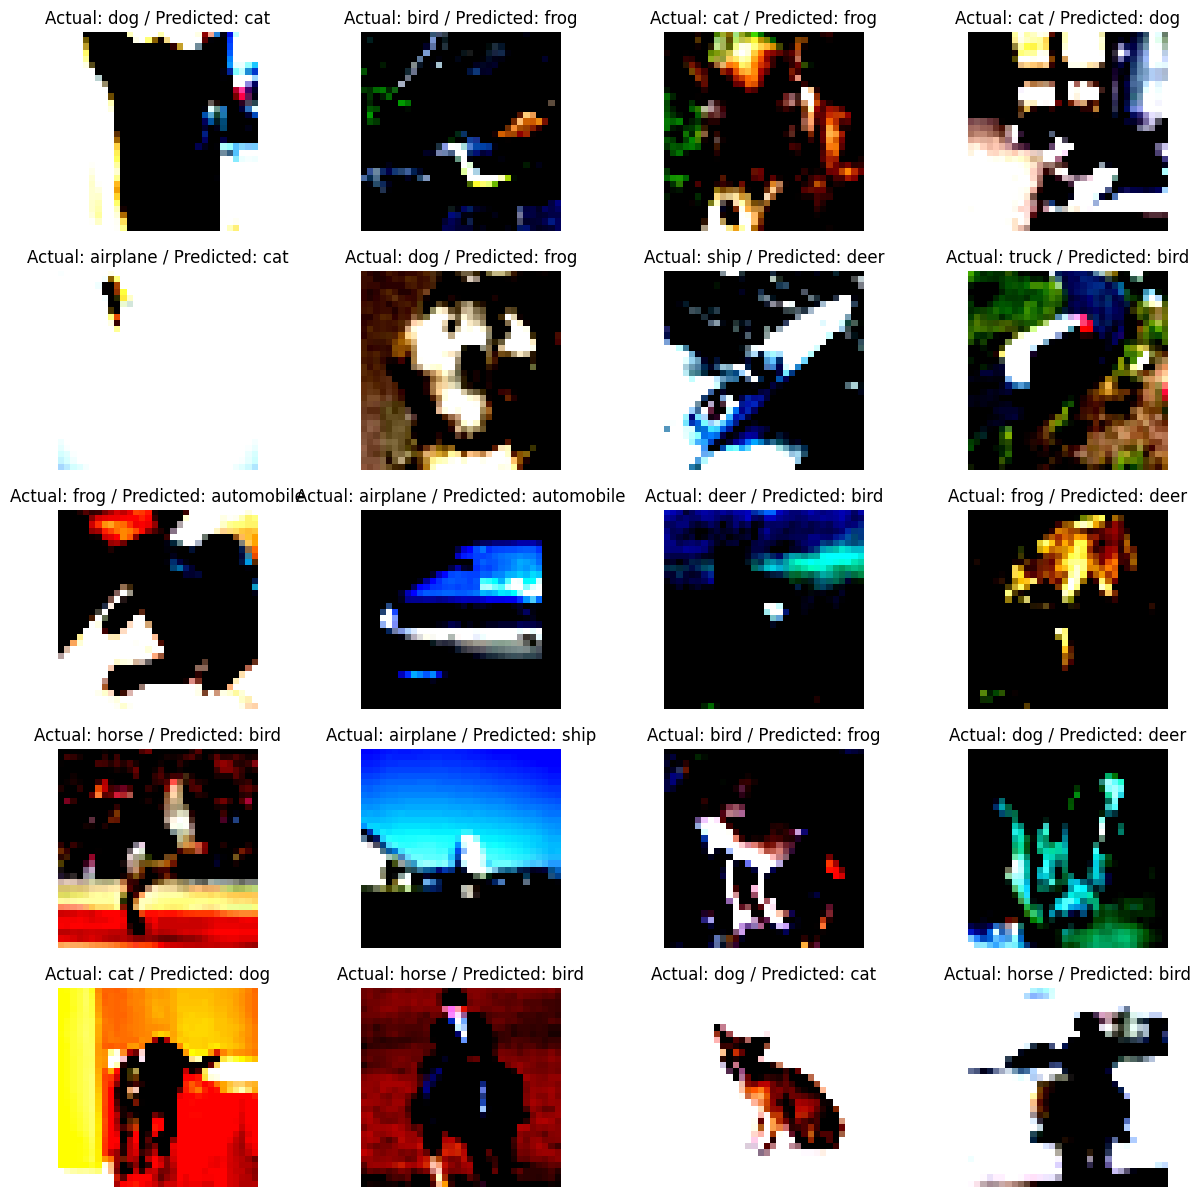

AttributeError: ignored

In [29]:
#Print the wrong predicted Image
targets, predicts, images = get_wrong_predictions(model, test_loader)
show_wrong_images(targets, predicts, images)


for model in model.items():
    targets, predicts, images = get_wrong_predictions(model, test_loader)
    show_wrong_images(targets, predicts, images)
    plt.show()

In [20]:
model

Net(
  (convblock1): Sequential(
    (0): depthwise_separable_conv(
      (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3, bias=False)
      (pointwise): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), dilation=(2, 2), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentu

In [ ]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 8
conv_layers


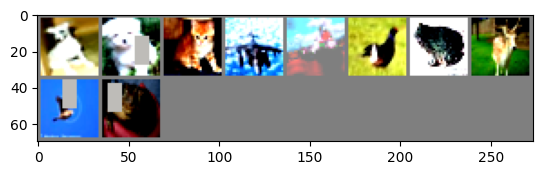

In [21]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

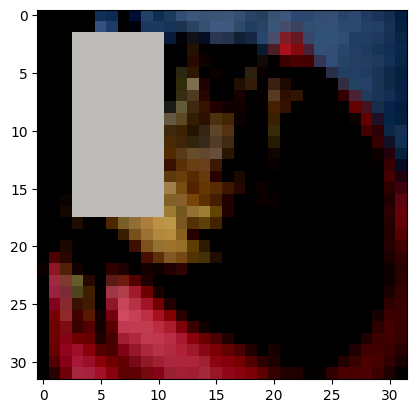

In [22]:
image = images[9]
imshow(image)

In [23]:
image = image.unsqueeze(0)
image = image.to(device)

In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

In [25]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

In [ ]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()